In [10]:
from typing import List
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import StepLR
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

In [11]:
from src import train, utils
from src import calculus as calc
import src.data.aquarium_domain as aq
from src.models.mlp_model import MLPModel

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
NU = 0.001
U_MAX = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

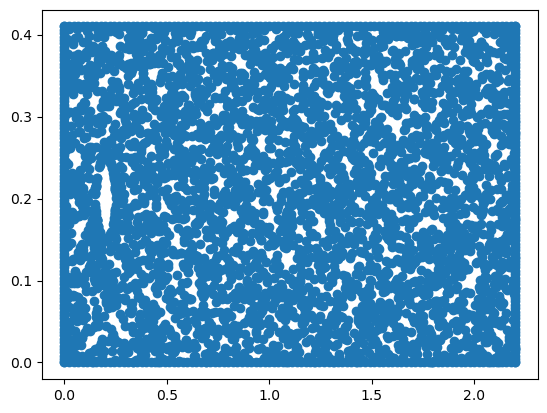

In [14]:
config = aq.SquareWithCircleDomainConfig(
    x_0=0,
    x_1=2.2,
    y_0=0,
    y_1=0.41,
    ball_x=0.2,
    ball_y=0.2,
    ball_r=0.05,
    device=device,
    ball_N=100,
    N_int=4_000,
    N_bottom=100,
    N_left=100,
    N_right=100,
    N_top=100,
    boundary_strategy='linear',
    interior_strategy='latin'
)

domain = aq.SquareWithCircleDomain(config)
domain.generate_points()

utils.plot_domain(domain)

In [15]:
#TODO: vymyslet lepsi system pro derivace

def loss_fn(model: torch.nn.Module, domain: aq.SquareWithCircleDomain) -> torch.Tensor:
    # ztrata na vnitrku
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = calc.compute_derivatives_ns(model, domain.interior)
    inner_loss_1 = torch.mean((-NU * (u_xx + u_yy) + u * u_x + v * u_y + p_x)**2)
    inner_loss_2 = torch.mean((-NU * (v_xx + v_yy) + u * v_x + v * v_y + p_y)**2)
    inner_loss = inner_loss_1 + inner_loss_2

    # ztrata na leve hranici
    _, v_left, u_left = calc.compute_derivatives_2d(model, domain.left_boundary, 0)

    inflow = 4 * U_MAX * domain.left_boundary[:, 1:2] * (domain.cfg.y_1 - domain.left_boundary[:, 1:2]) / (domain.cfg.y_1**2)
    left_loss = torch.mean((u_left - inflow)**2 + v_left**2)

    # ztrata na prave hranici
    in_right = domain.right_boundary.requires_grad_(True)
    out_right = model(in_right)
    psi_right, p_right = out_right[:, 0], out_right[:, 1]
    psi_right_grad = grad(psi_right, in_right, torch.ones_like(psi_right), create_graph=True)[0]
    v_right, u_right = -psi_right_grad[:, 0:1], psi_right_grad[:, 1:2]
    v_right_x = grad(v_right, in_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1]
    u_right_x = grad(u_right, in_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    right_loss = torch.mean((NU * u_right_x - p_right)**2 + v_right_x**2)

    # ztrata na horni hranici
    _, v_top, u_top = calc.compute_derivatives_2d(model, domain.top_boundary, 0)
    top_loss = torch.mean(v_top**2 + u_top**2)

    # ztrata na dolni hranici
    _, v_bottom, u_bottom = calc.compute_derivatives_2d(model, domain.bottom_boundary, 0)
    bottom_loss = torch.mean(v_bottom**2 + u_bottom**2)

    # ztrata na kouli
    _, v_ball, u_ball = calc.compute_derivatives_2d(model, domain.ball_boundary, 0)
    ball_loss = torch.mean(v_ball**2 + u_ball**2)

    total_loss = inner_loss + left_loss + right_loss + top_loss + bottom_loss + ball_loss
    return total_loss

def loss_fn_ref(model: torch.nn.Module, domain: aq.SquareWithCircleDomain) -> torch.Tensor:
    # ztrata na vnitrku
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = calc.compute_derivatives_ns(model, domain.interior)
    inner_loss_1 = torch.mean((-NU * (u_xx + u_yy) + u * u_x + v * u_y + p_x)**2)
    inner_loss_2 = torch.mean((-NU * (v_xx + v_yy) + u * v_x + v * v_y + p_y)**2)
    inner_loss = inner_loss_1 + inner_loss_2

    # ztrata na leve hranici
    in_left = domain.left_boundary.requires_grad_(True)
    out_left = model(in_left)
    psi_left = out_left[:, 0]
    psi_left_grad = grad(psi_left, in_left, torch.ones_like(psi_left), create_graph=True)[0]
    v_left, u_left = -psi_left_grad[:, 0:1], psi_left_grad[:, 1:2]

    inflow = 4 * U_MAX * in_left[:, 1:2] * (domain.cfg.y_1 - in_left[:, 1:2]) / (domain.cfg.y_1**2)
    left_loss = torch.mean((u_left - inflow)**2 + (v_left)**2)

    # ztrata na prave hranici
    in_right = domain.right_boundary.requires_grad_(True)
    out_right = model(in_right)
    psi_right, p_right = out_right[:, 0], out_right[:, 1]
    psi_right_grad = grad(psi_right, in_right, torch.ones_like(psi_right), create_graph=True)[0]
    v_right, u_right = -psi_right_grad[:, 0:1], psi_right_grad[:, 1:2]
    v_right_x = grad(v_right, in_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1]
    u_right_x = grad(u_right, in_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    right_loss = torch.mean((NU * u_right_x - p_right)**2) + torch.mean((v_right_x)**2)

    # ztrata na horni hranici
    in_top = domain.top_boundary.requires_grad_(True)
    out_top = model(in_top)
    psi_top = out_top[:, 0]
    psi_top_grad = grad(psi_top, in_top, torch.ones_like(psi_top), create_graph=True)[0]
    v_top, u_top = -psi_top_grad[:, 0:1], psi_top_grad[:, 1:2]

    top_loss = torch.mean((v_top)**2 + (u_top)**2)

    # ztrata na dolni hranici
    in_bottom = domain.bottom_boundary.requires_grad_(True)
    out_bottom = model(in_bottom)
    psi_bottom = out_bottom[:, 0]
    psi_bottom_grad = grad(psi_bottom, in_bottom, torch.ones_like(psi_bottom), create_graph=True)[0]
    v_bottom, u_bottom = -psi_bottom_grad[:, 0:1], psi_bottom_grad[:, 1:2]

    bottom_loss = torch.mean((v_bottom)**2 + (u_bottom)**2)

    # ztrata na kouli
    in_ball = domain.ball_boundary.requires_grad_(True)
    out_ball = model(in_ball)
    psi_ball = out_ball[:, 0]
    psi_ball_grad = grad(psi_ball, in_ball, torch.ones_like(psi_ball), create_graph=True)[0]
    v_ball, u_ball = -psi_ball_grad[:, 0:1], psi_ball_grad[:, 1:2]

    ball_loss = torch.mean((v_ball)**2 + (u_ball)**2)

    total_loss = inner_loss + left_loss + right_loss + top_loss + bottom_loss + ball_loss
    return total_loss

In [16]:
model = MLPModel(2, 2, [20, 20, 20, 20, 20]).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, 5_000, 0.9)

In [17]:
context = train.TrainingContext(
    model=model,
    domain=domain,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    epochs=20_000
)

loss_values = train.train_switch_to_lbfgs(context, 500)

Loss at epoch 1 is: 0.06397134810686111
Loss at epoch 100 is: 0.02285652980208397
Loss at epoch 200 is: 0.01699225604534149
Loss at epoch 300 is: 0.01401613187044859
Loss at epoch 400 is: 0.010158061049878597
Loss at epoch 500 is: 0.009857985191047192
Loss at epoch 600 is: 0.009636754170060158
Loss at epoch 700 is: 0.00885646604001522
Loss at epoch 800 is: 0.010289860889315605
Loss at epoch 900 is: 0.007836082018911839
Loss at epoch 1000 is: 0.006701959762722254
Loss at epoch 1100 is: 0.005981111433357
Loss at epoch 1200 is: 0.00567588908597827
Loss at epoch 1300 is: 0.006178522016853094
Loss at epoch 1400 is: 0.005056581925600767
Loss at epoch 1500 is: 0.005026364699006081
Loss at epoch 1600 is: 0.0050675030797719955
Loss at epoch 1700 is: 0.00494420388713479
Loss at epoch 1800 is: 0.004719289485365152
Loss at epoch 1900 is: 0.00441275117918849
Loss at epoch 2000 is: 0.004315503872931004
Loss at epoch 2100 is: 0.004459249787032604
Loss at epoch 2200 is: 0.004031334072351456
Loss at ep

In [ ]:
# vykresleni vyvoje ztraty
utils.plot_loss_values(loss_values, 'Epochs', 'Loss')

TypeError: plot_loss_values() missing 2 required positional arguments: 'x_label' and 'y_label'

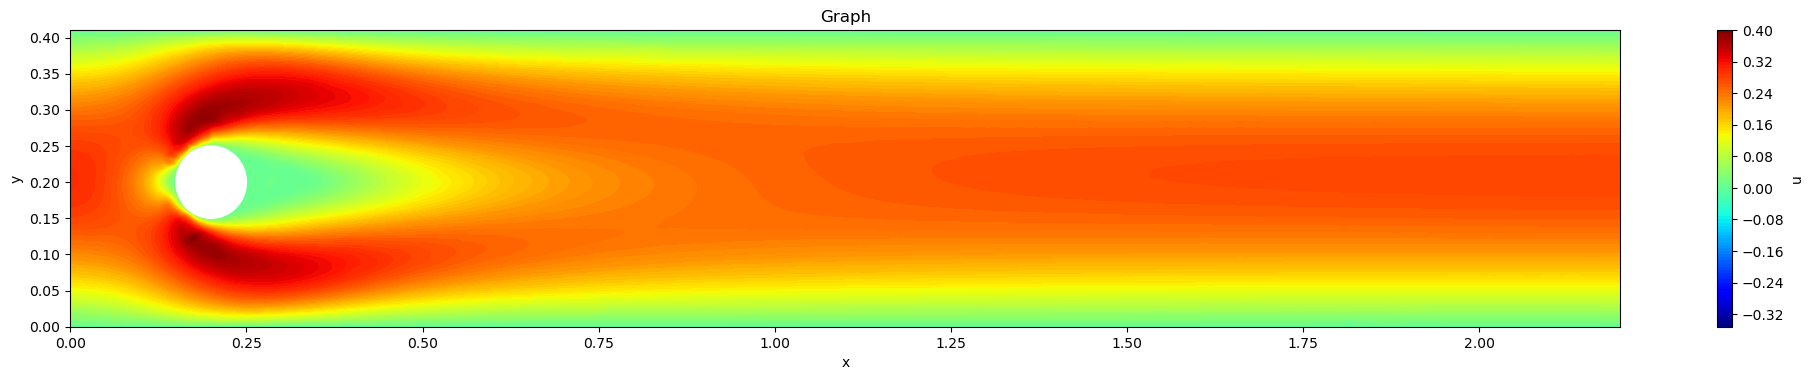

In [ ]:
# vykresleni rychlosti kapaliny

def u(x: torch.Tensor):
    p, u, v = calc.compute_derivatives_2d(model, x, 0)

    return torch.sqrt(u**2 + v**2)

plot_context = utils.PlotContext(
    function=u,
    domain=domain,
    figsize=(25,3.85),
    patches=[plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)]
)

utils.plot_function_on_domain(plot_context)